In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [2]:
with open('date_ngram.json', 'r', encoding='utf-8') as f:
    date_ngram = json.load(f)

In [3]:
data = [{"date": date, "ngrams": ngrams} for date, ngrams in date_ngram.items()]
df_dl = pd.DataFrame(data)

In [4]:
del data

In [5]:
df_dl.set_index('date', inplace=True)

In [6]:
with open('date_label.json', 'r', encoding='utf-8') as f:
    date_label = json.load(f)

In [7]:
df_dl['label'] = date_label

In [8]:
df_dl['label'] = df_dl['label'].astype(int)

In [9]:
df_train, df_test = train_test_split(df_dl, test_size=0.2, random_state=33)

In [44]:
count_0 = {}
count_1 = {}

In [45]:
def count(row):
    for ngram in row['ngrams']:
        if row['label'] == 0:
            count_0[ngram] = count_0.get(ngram, 0) + 1
        else:
            count_1[ngram] = count_1.get(ngram, 0) + 1

In [46]:
df_train.apply(count, axis=1)

date
2016-10-12    None
2023-04-07    None
2015-07-23    None
2015-04-16    None
2022-04-28    None
              ... 
2015-05-14    None
2017-01-23    None
2020-04-16    None
2016-10-14    None
2018-04-26    None
Length: 1015, dtype: object

In [47]:
print(len(count_0), len(count_1))

22620527 30750583


In [48]:
unique_ngram = list(set(list(count_0.keys()) + list(count_1.keys())))
df = pd.DataFrame([], index=unique_ngram)
del unique_ngram

df['count_0'] = count_0
del count_0

df['count_1'] = count_1
del count_1

In [49]:
df = df.fillna(0)

In [51]:
df['sum'] = df['count_0'] + df['count_1']

df = df[df['sum'] > 4]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1577569 entries, 수준 지난 to 중국 경기 하강
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   count_0  1577569 non-null  float64
 1   count_1  1577569 non-null  float64
 2   sum      1577569 non-null  float64
dtypes: float64(3)
memory usage: 48.1+ MB


In [54]:
df

,count_0,count_1,sum
수준 지난,89.0,208.0,297.0
충격 은행,5.0,6.0,11.0
개인 자료 투자 증권주 단위,10.0,6.0,16.0
보도 저널 따르,6.0,1.0,7.0
수요 올해 하루 배럴,0.0,10.0,10.0
...,...,...,...
긴축 통화정책 인플레이션,1.0,4.0,5.0
상무 전무 승진,3.0,5.0,8.0
시장 원화 약세 돌아섰,4.0,2.0,6.0
실업률 유지,21.0,24.0,45.0


In [55]:
# 사전 확률 계산
sum_0 = df['count_0'].sum()
sum_1 = df['count_1'].sum()
sum_tot = sum_0 + sum_1

df['prob_0'] = df['count_0'] / sum_0
df['prob_1'] = df['count_1'] / sum_1
print(f'sum_0: {sum_0}, sum_1: {sum_1}, sum_tot: {sum_tot}')

sum_0: 23132980.0, sum_1: 32761059.0, sum_tot: 55894039.0


In [78]:
df.value_counts()

count_0  count_1  sum       prob_0        prob_1      
0.0      5.0      5.0       0.000000e+00  1.526202e-07    96833
2.0      3.0      5.0       8.645665e-08  9.157213e-08    64834
1.0      4.0      5.0       4.322833e-08  1.220962e-07    60997
3.0      2.0      5.0       1.296850e-07  6.104809e-08    55679
5.0      0.0      5.0       2.161416e-07  0.000000e+00    52659
                                                          ...  
48782.0  66578.0  115360.0  2.108764e-03  2.032230e-03        1
42031.0  57867.0  99898.0   1.816930e-03  1.766335e-03        1
40171.0  86797.0  126968.0  1.736525e-03  2.649395e-03        1
35481.0  23480.0  58961.0   1.533784e-03  7.167045e-04        1
35463.0  54747.0  90210.0   1.533006e-03  1.671100e-03        1
Name: count, Length: 30592, dtype: int64

In [57]:
def predict(ngrams):
    # set basic probability
    log_prob_0 = np.log(sum_0/sum_tot)
    log_prob_1 = np.log(sum_1/sum_tot)

    i = 0
    for ngram in ngrams:
        if ngram in df.index:
            # get log probability for both labels
            log_prob_0 += np.log(df.at[ngram, 'prob_0'])
            log_prob_1 += np.log(df.at[ngram, 'prob_1'])
    # compare and return the result
    return log_prob_0 < log_prob_1


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [59]:
df_test.rename(columns={'label': 'y_true'}, inplace=True)

In [40]:
df_test['y_pred'] = df_test['ngrams'].apply(predict)

True
-7.857455453613798 -7.409392192619663
True
-18.4007663593635 -17.589665072560233
True
-28.07340141608536 -27.151146514165223
True
-35.04865843702853 -34.026321553631185
True
-45.17563456243317 -44.04899903797171
True
-52.150891583376335 -50.92417407743768
True
-57.63096437593045 -56.421369377924265
True
-67.68097946019896 -66.52494963707659
True
-75.54968958584867 -74.37735584857927
True
-82.0483399355264 -80.94575379474811
True
-88.79520429140041 -87.76656309155533
True
-9.574090032785946 -8.979462811068561
True
-18.26598163290126 -17.424708468983425
True
-26.95787323301657 -25.869954126898286
True
-35.64976483313188 -34.315199784813146
True
-42.868924647890836 -41.513114450724984
True
-50.08808446264979 -48.71102911663682
True
-57.30724427740874 -55.90894378254866
True
-64.5264040921677 -63.1068584484605
True
-71.48514924872464 -70.1381114112346
True
-78.44389440528158 -77.16936437400871
True
-85.40263956183853 -84.20061733678281
True
-7.790904321944322 -7.556873089113284
True
-

In [61]:
df_test['y_pred'] = df_test['y_pred'].astype(int)

In [77]:
df_test.info(), df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 2023-02-13 to 2022-02-22
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ngrams   254 non-null    object
 1   y_true   254 non-null    int64 
 2   y_pred   254 non-null    int64 
 3   correct  254 non-null    bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 16.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 2016-10-12 to 2018-04-26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ngrams  1015 non-null   object
 1   label   1015 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.1+ KB


(None, None)

In [62]:
accuracy = accuracy_score(df_test['y_true'], df_test['y_pred'])
precision = precision_score(df_test['y_true'], df_test['y_pred'])
recall = recall_score(df_test['y_true'], df_test['y_pred'])
f1 = f1_score(df_test['y_true'], df_test['y_pred'])
print(f'Accuracy: {accuracy:.6f}\nPrecision: {precision:.6f}\nRecall: {recall:.6f}\nF1: {f1:.6f}')

Accuracy: 0.618110
Precision: 0.609272
Recall: 0.707692
F1: 0.654804


In [63]:
# df_test.value_counts('y_true')
df_test.value_counts('y_pred')

y_pred
1    151
0    103
Name: count, dtype: int64

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

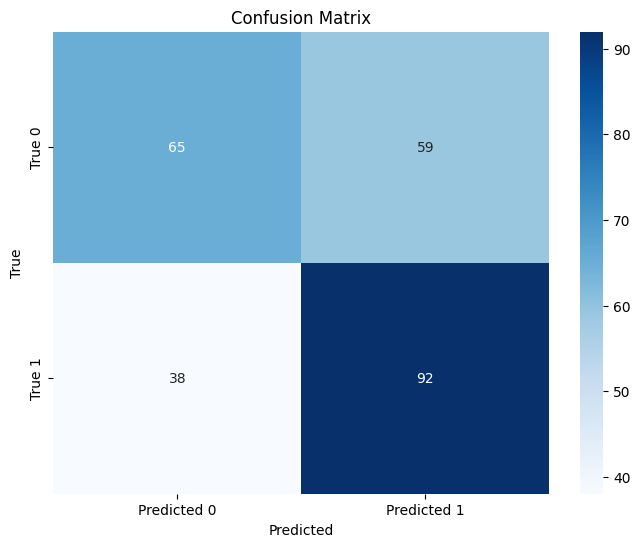

In [74]:
cm = confusion_matrix(df_test['y_true'], df_test['y_pred'])

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

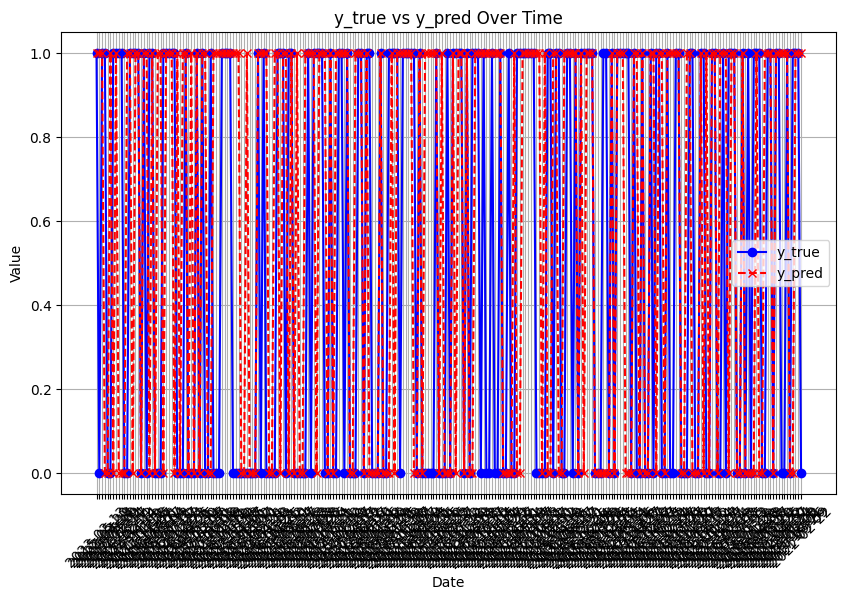

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['y_true'], marker='o', label='y_true', linestyle='-', color='b')
plt.plot(df_test.index, df_test['y_pred'], marker='x', label='y_pred', linestyle='--', color='r')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('y_true vs y_pred Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\s_torileeo99\AppData\Local\Temp\ipykernel_17216\4277112352.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Sum', data=data, palette='husl')


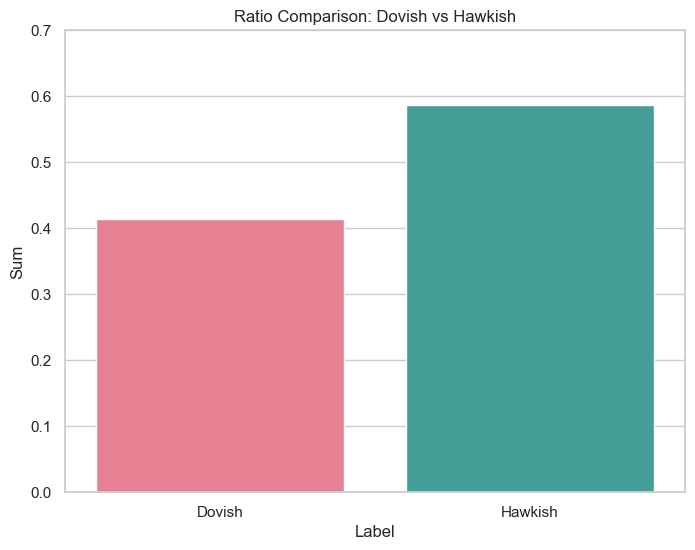

In [86]:
# 데이터프레임 생성
data = pd.DataFrame({
    'Label': ['Dovish', 'Hawkish'],
    'Sum': [sum_0/sum_tot, sum_1/sum_tot]
})

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
sns.barplot(x='Label', y='Sum', data=data, palette='husl')

# 그래프 설정
plt.title('Ratio Comparison: Dovish vs Hawkish')
plt.ylim(0, 0.7)  # y축 범위 설정
plt.show()